In [1]:
import numpy as np
import numpy.random as npr
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import time
import networkx as nx
import networkx.algorithms.bipartite as bpt
import networkx.algorithms.isomorphism as iso
import scipy.sparse as sp
import sys

### Graph manipulation utilities

In [2]:
def load_tanner_graph(filename):
    m, n = np.loadtxt(filename, max_rows=1, dtype=int)
    indices, indptr = np.array([], dtype=int), [0]
    for r in range(m):
        r_ind = np.loadtxt(filename, skiprows=r+1, max_rows=1, dtype=int)
        indices = np.concatenate([indices, np.sort(r_ind)])
        indptr.append(len(r_ind))
    
    H = sp.csr_array((m, n), dtype=int)
    H.data = np.ones_like(indices, dtype=int)
    H.indices = indices
    H.indptr = np.cumsum(indptr)

    return bpt.from_biadjacency_matrix(H, create_using=nx.MultiGraph)

def graph_transpose(G: nx.Graph) -> nx.Graph:
    a = [n for n, b in G.nodes(data='bipartite') if b == 0]
    return bpt.from_biadjacency_matrix(bpt.biadjacency_matrix(G, row_order=a).T, create_using=nx.Graph)

### Visualization utilities

In [3]:
def draw_bpt_graph(G: nx.MultiGraph, ax=None):
    checks = [n for n, b in G.nodes(data='bipartite') if b == 0]
    bits = [n for n, b in G.nodes(data='bipartite') if b == 1]
    pos = nx.layout.bipartite_layout(G, checks)
    
    # Draw the graph
    if ax is None:
        plt.figure(figsize=(5, 4))
        
    nx.draw(G, pos, with_labels=True, ax=ax,
            node_color=['grey' if n in checks else 'purple' for n in G.nodes()], 
            edge_color=[u%10 for (u, *_) in G.edges], edge_cmap=plt.cm.tab10, edge_vmin=0, edge_vmax=9,
            labels={n: ('$c_{%}$'.replace('%', str(n+1)) if n in checks \
                        else '$n_{%}$'.replace('%', str(n+1-len(checks)))) for n in G.nodes()},
           )
    if ax is None:
        plt.show()

def split_linear_bpt_layout(G: nx.graph) -> dict[int: float]:
    l, h = -1, 1
    box = (h-l)/G.number_of_nodes()
    return {n: n*box + box/4 if b == 0 else n*box + box*3/4 for n, b in G.nodes(data='bipartite')}
    
def hgp_layout(G1: nx.Graph, G2: nx.Graph) -> dict[int: float]:
    # Assume G1 = (C1 u V1, E1), G2 = (C2 u V2, E2)
    # Display H = HGP(G1, G2) as
    # C1xC2 V1xC2
    # C1xV2 V1xV2
    h_layout = split_linear_bpt_layout(G1)
    v_layout = split_linear_bpt_layout(G2)
    return {(n1, n2): np.array([h_layout[n1], v_layout[n2]]) - 1 \
            for n1 in G1.nodes for n2 in G2.nodes}

def draw_hgp_graph(G: nx.Graph, nodesize:int=500, fontsize:int=8, ax=None):
    Gt = graph_transpose(G)
    c = [n for n, b in G.nodes(data='bipartite') if b == 0]
    v = [n for n, b in G.nodes(data='bipartite') if b == 1]
    vt = [n for n, b in Gt.nodes(data='bipartite') if b == 0]
    ct = [n for n, b in Gt.nodes(data='bipartite') if b == 1]
    
    HGP = nx.cartesian_product(G, Gt)
    
    X_pos, X_neg, Z_pos, Z_neg = [], [], [], []
    
    for (x1, y1), (x2, y2) in HGP.edges(data=False):
        if y1 == y2 and y1 in vt:
            X_pos.append(((x1, y1), (x2, y2)))
        if x1 == x2 and x1 in c:
            X_neg.append(((x1, y1), (x2, y2)))
        if x1 == x2 and x1 in v:
            Z_pos.append(((x1, y1), (x2, y2)))
        if y1 == y2 and y1 in ct:
            Z_neg.append(((x1, y1), (x2, y2)))
    
    C, V = bpt.sets(HGP)
    C = [n for n, b in HGP.nodes(data='bipartite') if b[0] == b[1]]
    V = [n for n, b in HGP.nodes(data='bipartite') if b[0] != b[1]]
    pos = hgp_layout(G, Gt)
    
    if ax is None:
        plt.figure(figsize=(8,8))
        
    nx.draw_networkx_edges(HGP, pos, edgelist=X_pos, arrows=True, ax=ax,
                           connectionstyle='arc3,rad=+0.3', edge_color='b')
    nx.draw_networkx_edges(HGP, pos, edgelist=Z_pos, arrows=True, ax=ax, 
                           connectionstyle='arc3,rad=+0.3', edge_color='r')
    nx.draw_networkx_edges(HGP, pos, edgelist=Z_neg, arrows=True, ax=ax, 
                           connectionstyle='arc3,rad=-0.3', edge_color='r')
    nx.draw_networkx_edges(HGP, pos, edgelist=X_neg, arrows=True, ax=ax, 
                           connectionstyle='arc3,rad=-0.3', edge_color='b')
    nx.draw_networkx_nodes(HGP, pos, nodelist=C, node_color='grey', 
                           node_shape='s', node_size=nodesize, ax=ax)
    nx.draw_networkx_nodes(HGP, pos, nodelist=V, node_color='purple', 
                           node_shape='o', node_size=nodesize, ax=ax)
    
    parse_label = lambda nn: ('$c_{%} '.replace('%', str(1+nn[0])) if nn[0] in c else \
               '$v_{%} '.replace('%', str(1+nn[0] - len(c)))) + (
                'c_{%}$'.replace('%', str(1+nn[1] - len(vt))) if nn[1] in ct else \
               'v_{%}$'.replace('%', str(1+nn[1])))
    nx.draw_networkx_labels(HGP, pos, labels={nn: parse_label(nn) for nn in HGP.nodes}, 
                           font_size=fontsize, ax=ax)
    if ax is None:
        plt.annotate('$X$', (-1.25, -1.15), color='b', fontsize=24)
        plt.annotate('$Z$', (+1.1, +1.05), color='r', fontsize=24)
        plt.show()
    else:
        ax.annotate('$X$', (-1.25, -1.15), color='b', fontsize=24)
        ax.annotate('$Z$', (+1.1, +1.05), color='r', fontsize=24)


### draft

In [4]:
import pym4ri as m4ri
from css_code_eval import CSS_HGP_code_from_state
import css_code_eval as css

In [5]:
def MC_erasure_plog(num_trials: int, state: nx.MultiGraph, p_vals: list[float]=None) -> dict:
    # Compute CSS code for the HGP induced by the state
    H, N_qubits, _ = CSS_HGP_code_from_state(state)
    Hx, Hz = np.vsplit(H.todense(), 2)

    # Compute the parity-check matrices of Cz^\perp and Cx^\perp
    etaHz = m4ri.gen2chk(Hz)
    etaHx = m4ri.gen2chk(Hx)

    # Register mean and std of the Monte Carlo estimates
    est_plog = {'mean': [], 'std': []}

    for p in p_vals:
        trials = []
        for _ in range(num_trials):
            # IID erasure with probability p (physical error rate)
            E = npr.rand(N_qubits) < p

            # Generate the Cx and Cz intersections with the erasure support
            gammaHxE = m4ri.chk2gen(Hx[:, E])
            gammaHzE = m4ri.chk2gen(Hz[:, E])

            # Check for the existence of logical errors hiding in the erasure
            z_logical_error = m4ri.gf2_mul(etaHz[:, E], gammaHxE).any()
            x_logical_error = m4ri.gf2_mul(etaHx[:, E], gammaHzE).any()

            # Failure criterion: the erasure hides a logical error of either type
            failure = z_logical_error or x_logical_error
            trials.append(1. if failure else 0.)

        trials = np.array(trials)
        est_plog['mean'].append(trials.mean())
        est_plog['std'].append(trials.std())

    return est_plog


In [24]:
codes = ['[625,25]', '[1225,65]', '[1600,64]', '[2025,81]']
textfiles = ["../initial_codes/"+f"HGP_(3,4)_{code}.txt" for code in codes]

new_state = load_tanner_graph(textfiles[0])
num_trials = int(1e4)
p_vals = np.linspace(1e-1, 3e-1, 11)
# p_vals = [0.8]

In [22]:
# Exact or eta-gamma approach
print(f"Method: Eta-Gamma approach\n{num_trials = }, {len(p_vals) = }")

print("Python version")
%timeit plain_MC = MC_erasure_plog(num_trials, new_state, p_vals)

print("C version")
%timeit results = css.MC_erasure_plog(num_trials, new_state, p_vals)

Method: Eta-Gamma approach
num_trials = 1000, len(p_vals) = 1
Python version
6.57 s ± 1.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
C version
2.51 s ± 139 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
MC_py = MC_erasure_plog(num_trials, new_state, p_vals)
MC_C = css.MC_erasure_plog(num_trials, new_state, p_vals)

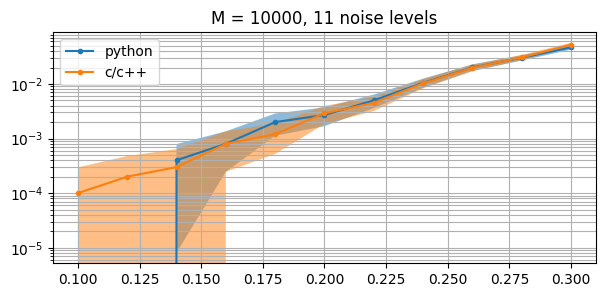

In [34]:
plt.figure(figsize=(7, 3))
plt.title(f"M = {num_trials}, {len(p_vals)} noise levels")

for data, name in zip([MC_py, MC_C], 
                      ['python', 'c/c++']):
    m = np.array(data['mean'])
    s = np.array(data['std'])
    plt.semilogy(p_vals, m, '.-', label=name)
    plt.fill_between(p_vals, m - 1.96*s/np.sqrt(num_trials), 
                     m + 1.96*s/np.sqrt(num_trials), alpha=0.5)
    

plt.legend()
plt.grid(which='both')
plt.show()

In [9]:
H, N, k = CSS_HGP_code_from_state(new_state)

In [10]:
Hx, Hz = np.vsplit(H.todense(), 2)
Hx.shape, Hz.shape

((300, 625), (300, 625))

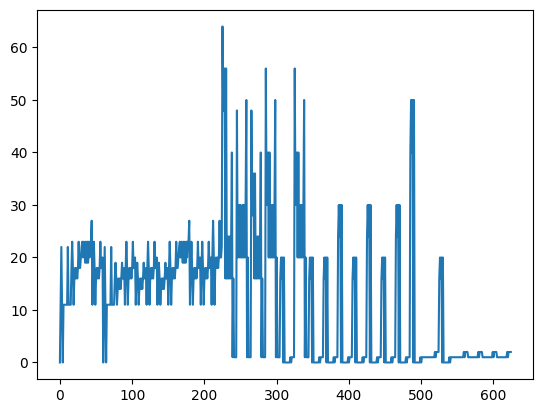

In [112]:
eta_Hx = m4ri.gen2chk(Hx)
gamma_Hz = m4ri.chk2gen(Hz)
X_error = m4ri.gf2_mul(eta_Hx, gamma_Hz)
gamma_Hz[:, X_error.any(axis=0)].sum(axis=0)

eta_Hz = m4ri.gen2chk(Hz)
gamma_Hx = m4ri.chk2gen(Hx)
Z_error = m4ri.gf2_mul(eta_Hz, gamma_Hx)
gamma_Hx[:, Z_error.any(axis=0)].sum(axis=0)

errors = np.hstack([gamma_Hz[:, X_error.any(axis=0)], gamma_Hx[:, Z_error.any(axis=0)]])
errors = np.unique(errors, axis=1).T
plt.plot(errors.sum(axis=0))
# plt.matshow(errors)

In [264]:
N_qubits = N
num_probe_trials = 1000

# bootstrap = np.ones(N_qubits)*0.5
bootstrap = np.copy(criticality_score)
# bootstrap = density

criticality_score = np.zeros(N_qubits)
count = 0

for _ in range(num_probe_trials):
    # IID erasure with probability p (physical error rate)
    E = npr.rand(N_qubits) < bootstrap

    # Generate the Cx and Cz intersections with the erasure support
    gammaHxE = m4ri.chk2gen(Hx[:, E])
    gammaHzE = m4ri.chk2gen(Hz[:, E])

    # Check for the existence of logical errors hiding in the erasure
    z_logical_error = m4ri.gf2_mul(eta_Hz[:, E], gammaHxE).any()
    x_logical_error = m4ri.gf2_mul(eta_Hx[:, E], gammaHzE).any()

    # Failure criterion: the erasure hides a logical error of either type
    failure = z_logical_error or x_logical_error
    if failure:
        criticality_score += E
        count += 1
    # else:
    #     criticality_score -= E

criticality_score /= num_probe_trials
diam = criticality_score.max() - criticality_score.min()
interp = lambda x: 0.05 + 0.95*(x - x.min())/(x.max() - x.min())
criticality_score = interp(criticality_score)

992


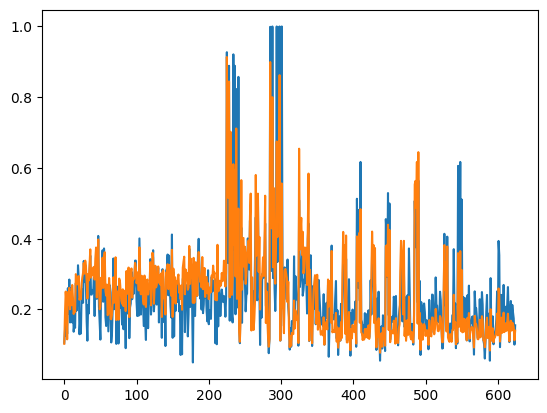

In [275]:
plt.plot(criticality_score)
plt.plot(density*.5 + criticality_score*.5)
# density = errors.sum(axis=0)
# density = interp(density)
# plt.plot(density)
print(count)

# Graph Visualizations

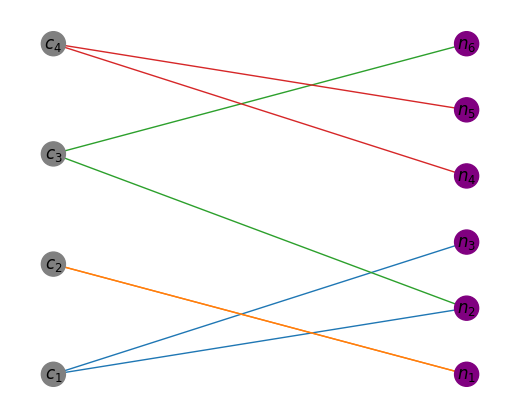

In [5]:
G = bpt.configuration_model(aseq=[2, 2, 2, 2], 
                            bseq=[2, 2, 1, 1, 1, 1], 
                            create_using=nx.MultiGraph())
draw_bpt_graph(G)

# Cross-wiring edges

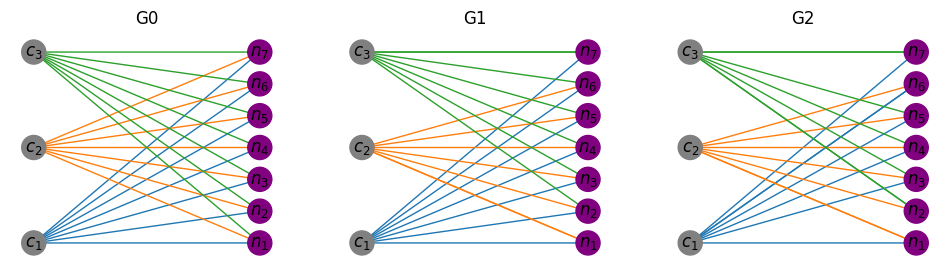

[(0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9)]
[(0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 3), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 9)]
[(0, 3), (0, 5), (0, 6), (0, 7), (0, 8), (0, 8), (0, 9), (1, 3), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 4), (2, 4), (2, 5), (2, 6), (2, 7), (2, 9), (2, 9)]


In [7]:
from simulated_annealing import generate_neighbor

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 3))

ax0.set_title('G0')
G0 = nx.MultiGraph(bpt.gnmk_random_graph(3, 7, 36))
draw_bpt_graph(G0, ax0)

ax1.set_title('G1')
G1 = generate_neighbor(G0)
draw_bpt_graph(G1, ax1)

ax2.set_title('G2')
G2 = generate_neighbor(G1)
draw_bpt_graph(G2, ax2)

plt.show()

print(sorted(G0.edges(data=False)))
print(sorted(G1.edges(data=False)))
print(sorted(G2.edges(data=False)))

MultiEdgeDataView([(0, 3), (0, 4), (0, 5), (0, 6), (0, 8), (0, 9), (0, 9), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 8), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 7), (2, 9)])

# State Representation and Indexing

In order to keep track of the visited states and map their representation to the corresponding PS structures (namely, the $h$ and $g$ matrices, and a reward cache), we'll introduce the StateIndexer class. 

Since the error correcting properties of a code are invariant by graph isomorphism of its Tanner graph (equivalently, by permutation of the qubits and of the check nodes), it might be interesting to index states by taking into account isomorphism equivalence classes. One way to do it is via Graph Canonization. 

In [81]:
from state_indexer import GraphSerializer

## Testing:

### Serialization/Deserialization

In [75]:
# Create a random graph from its biadjacency matrix. Let's allow for a few multiedges. 
m, n = (3, 7)
x = npr.randint(0, 3, (3, 7), dtype=np.uint8)
G = bpt.from_biadjacency_matrix(sp.csr_matrix(x), create_using=nx.MultiGraph())
x, G.edges

(array([[0, 1, 0, 2, 2, 0, 2],
        [2, 0, 2, 2, 0, 1, 0],
        [1, 1, 1, 0, 0, 0, 2]], dtype=uint8),
 MultiEdgeView([(0, 4, 0), (0, 6, 0), (0, 6, 1), (0, 7, 0), (0, 7, 1), (0, 9, 0), (0, 9, 1), (1, 3, 0), (1, 3, 1), (1, 5, 0), (1, 5, 1), (1, 6, 0), (1, 6, 1), (1, 8, 0), (2, 3, 0), (2, 4, 0), (2, 5, 0), (2, 9, 0), (2, 9, 1)]))

In [79]:
# Now serialize it and then deserialize it
state_indexer = GraphSerializer(graph_dims=(m, n))
d_serial = state_indexer.serialize_dense(G)
s_serial = state_indexer.serialize_sparse(G)
d_serial, s_serial

(b'\x00\x01\x00\x02\x02\x00\x02\x02\x00\x02\x02\x00\x01\x00\x01\x01\x01\x00\x00\x00\x02',
 b'\x00\x04\x08\x0c\x01\x03\x04\x06\x00\x02\x03\x05\x00\x01\x02\x06\x01\x02\x02\x02\x02\x02\x02\x01\x01\x01\x01\x02')

In [80]:
rec_G_d = state_indexer.deserialize_dense(d_serial)
rec_G_s = state_indexer.deserialize_sparse(s_serial)
assert rec_G_d.__class__ == nx.MultiGraph
assert rec_G_s.__class__ == nx.MultiGraph
assert (x == bpt.biadjacency_matrix(rec_G_d, row_order=np.arange(m)).astype(np.uint8).todense()).all()
assert (x == bpt.biadjacency_matrix(rec_G_s, row_order=np.arange(m)).astype(np.uint8).todense()).all()
assert nx.utils.graphs_equal(rec_G_d, G)
assert nx.utils.graphs_equal(rec_G_s, G)

## Graph Canonization

In [82]:
import pynauty as nauty

In [99]:
def nx_to_nauty(G: nx.MultiGraph) -> nauty.Graph:
    Gs = nx.Graph(G)
    return nauty.Graph(number_of_vertices=Gs.number_of_nodes(), directed=True,
                       adjacency_dict={
                           n: list(Gs.neighbors(n)) for n, b in Gs.nodes(data='bipartite') if b == 0
                       })

    
# This is to convert from the serialized nauty certificate to nx. 
# def nauty_to_nx(g: nauty.Graph, E: int) -> nx.MultiGraph:
#     # E is the desired number of edges, which will be added 
#     # as duplicates of the very first edge in the whole graph
#     G = nx.Graph()
#     lines = certificate.splitlines()
#     for i, line in enumerate(lines):
#         neighbors = line.split()
#         for neighbor in neighbors:
#             G.add_edge(i, int(neighbor))
#     return G

In [100]:
g = nx_to_nauty(G)

In [104]:
nauty.canon_graph(g)

Graph(number_of_vertices=10, directed=True,
 adjacency_dict = {
  0: [],
  1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [0, 1, 2, 3],
  8: [0, 1, 4, 5],
  9: [2, 3, 4, 6],
 },
 vertex_coloring = [
 ],
)

# Sparse Matrix formats

In [229]:
# %%timeit
S, A = 7, 30
h = sp.csr_array((S, A), dtype=np.float32)
g = sp.dok_array((S, A), dtype=np.float32)

gamma = 1e-3
eta = 1e-2
reward = 1

num_steps = 100
for _ in range(num_steps):
    h *= 1-gamma
    h += reward*g
    g *= 1-eta
    i, j = npr.randint(0, S), npr.randint(0, A)
    g[i, j] = 1

In [230]:
h.__dict__

{'_shape': (7, 30),
 'maxprint': 50,
 'indices': array([ 7,  2, 27, 28, 24, 21, 19, 10, 25,  4, 24,  8, 20,  6, 17, 15,  0,
        21, 27,  7,  3, 28, 19, 13,  1, 20, 29, 19,  9,  6, 17, 24, 11,  8,
        27,  5, 17, 22,  0, 11,  9,  4,  8, 18, 12, 10, 21,  7,  1,  2,  9,
        19, 27, 14, 15,  3, 17, 10, 29,  2, 21,  8,  4, 18,  1,  6, 14, 10,
        17,  3, 27, 29, 14,  6,  7, 11,  2, 25, 20,  1, 24], dtype=int32),
 'indptr': array([ 0,  8, 23, 35, 49, 59, 70, 81], dtype=int32),
 'data': array([18.831207 , 58.397495 , 51.21117  , 46.773674 , 41.767956 ,
        37.313423 , 25.752487 ,  5.837204 , 10.412954 , 12.172966 ,
        26.350801 , 27.75468  , 43.33285  , 46.299633 , 56.92133  ,
        43.842205 , 41.792587 , 28.444656 , 27.056755 , 18.03133  ,
        11.297879 ,  9.51809  ,  1.9890001, 17.772974 , 20.404112 ,
        24.406725 , 34.309803 , 40.14647  , 58.651554 , 53.234306 ,
        56.22057  , 58.88168  , 44.842857 , 47.821476 , 34.924595 ,
        41.079227 , 41.2

In [231]:
h.resize((30, 35))
h

<30x35 sparse array of type '<class 'numpy.float32'>'
	with 81 stored elements in Compressed Sparse Row format>

In [232]:
sp.csr_array(h.todense())

<30x35 sparse array of type '<class 'numpy.float32'>'
	with 81 stored elements in Compressed Sparse Row format>

In [108]:
# csc/csc = 319ms +- 7.57ms
# coo/dok = 448ms +- 8.85ms
# csc/dok = 495ms +- 14.4ms
# csr/dok = 464ms +- 17.6ms
# lil/dok = 19.2s +- 1.67s
# lil/lil = 27s +- 82.5ms

# Decoding the HGP code

## Visualizing HGP codes

In [78]:
from agent import PSAgent
from rl_environment import QECEnv

In [79]:
d_m, d_n = 4, 3
E = 1*np.lcm(d_m, d_n)
m, n = E//d_m, E//d_n
env = QECEnv((m, n, E), 1.)

In [80]:
# Exact or eta-gamma approach
print(f"Method: Eta-Gamma approach\n{num_trials = }, {p_vals.size = }")

print("Python version")
%timeit plain_MC = MC_erasure_plog(num_trials, env.state, p_vals)

print("C version")
%timeit results = css.MC_erasure_plog(num_trials, env.state, p_vals)

Method: Eta-Gamma approach
num_trials = 10000, p_vals.size = 11
Python version
4.31 s ± 30.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
C version
2.36 s ± 74.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


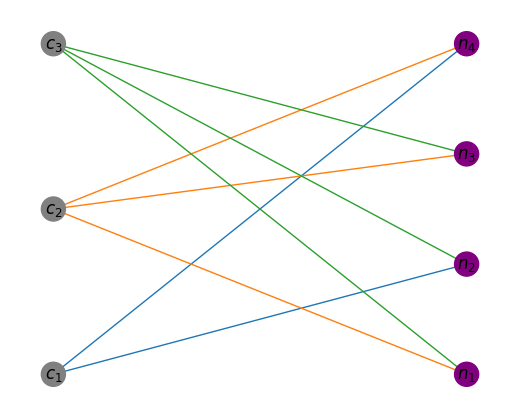

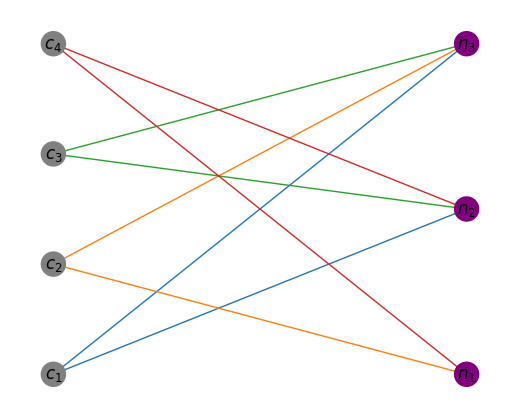

In [10]:
G = nx.Graph(env.state)
Gt = graph_transpose(G)

c, v = bpt.sets(G)
vt, ct = bpt.sets(Gt)

H1 = bpt.biadjacency_matrix(G, row_order=sorted(c), column_order=sorted(v), dtype=np.bool_)
H2 = bpt.biadjacency_matrix(Gt, row_order=sorted(vt), column_order=sorted(ct), dtype=np.bool_)

draw_bpt_graph(G)

draw_bpt_graph(graph_transpose(G))

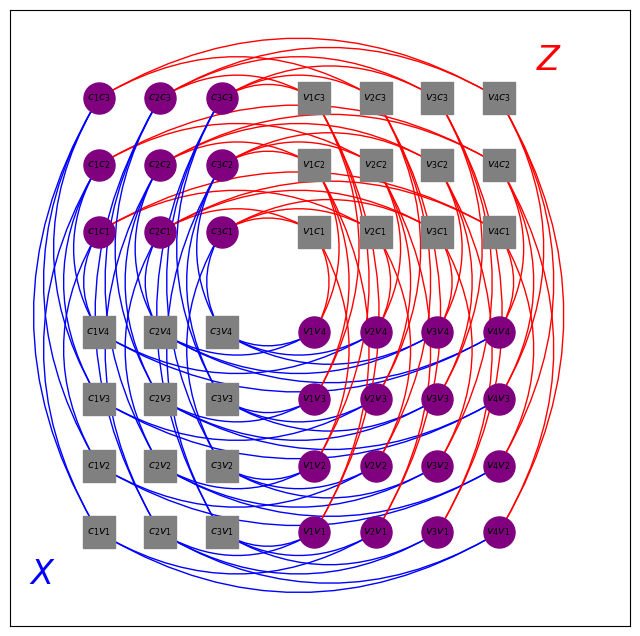

In [11]:
draw_hgp_graph(G)

In [12]:
# Hx = sp.hstack([sp.kron(sp.eye_array(m), H2), # Im x H2
#                 sp.kron(H1, sp.eye_array(n)), # H1 x In  
#                ], dtype=np.bool_) # [ Im x H2 | H1 x In ] } m*n rows

# Hz = sp.hstack([sp.kron(H1.T, sp.eye_array(m)), # H1'x Im
#                 sp.kron(sp.eye_array(n), H2.T), # In x H2'
#                ], dtype=np.bool_) # [ H1'x Im | In x H2'] } m*n rows

# H = sp.vstack([Hx, Hz]).asformat('csc')

# assert (H.todense() == bpt.biadjacency_matrix(HGP, row_order=sorted(C), 
#                                               column_order=sorted(V)).todense()).all()

## Evaluating HGP codes in the erasure channel

In [4]:
import css_code_eval as css

codes = ['[625,25]', '[1225,65]', '[1600,64]', '[2025,81]']
textfiles = ["../initial_codes/"+f"HGP_(3,4)_{code}.txt" for code in codes]

In [5]:
new_state = load_tanner_graph(textfiles[0])
num_trials = int(1e3)
p_vals = np.linspace(1e-1, 3e-1, 11)

results = css.MC_erasure_plog(num_trials, new_state, p_vals, rank_method=True)

In [15]:
results

{'mean': array([0.   , 0.   , 0.   , 0.001, 0.003, 0.002, 0.007, 0.01 , 0.026,
        0.031, 0.059]),
 'std': array([0.        , 0.        , 0.        , 0.03162278, 0.0547174 ,
        0.04469897, 0.08341438, 0.09954853, 0.15921479, 0.17340435,
        0.2357426 ]),
 'rank_stats': array([1.   , 0.997, 0.998, 0.999, 0.995, 0.99 , 0.987, 0.972, 0.957,
        0.916, 0.86 ])}

In [5]:
# Rank based
print(f"Method: Rank based\n{num_trials = }, {p_vals.size = }")
%timeit results = css.MC_erasure_plog(num_trials, new_state, p_vals, rank_method=True)

# # Rank based
# print(f"Method: Rank based: only X\n{num_trials = }, {p_vals.size = }")
# %timeit results = css.MC_erasure_plog(num_trials, new_state, p_vals, rank_method=True, only_X=True)

# Exact or eta-gamma approach
print(f"Method: Eta-Gamma approach\n{num_trials = }, {p_vals.size = }")
%timeit results = css.MC_erasure_plog(num_trials, new_state, p_vals)

# # Exact or eta-gamma approach
# print(f"Method: Eta-Gamma approach: only X\n{num_trials = }, {p_vals.size = }")
# %timeit results = css.MC_erasure_plog(num_trials, new_state, p_vals, only_X=True)

Method: Rank based
num_trials = 1000, p_vals.size = 11
21.8 s ± 1.38 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Method: Rank based: only X
num_trials = 1000, p_vals.size = 11
14.6 s ± 1.56 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Method: Eta-Gamma approach
num_trials = 1000, p_vals.size = 11
7.07 s ± 259 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Method: Eta-Gamma approach: only X
num_trials = 1000, p_vals.size = 11
3.36 s ± 22.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
new_state = load_tanner_graph(textfiles[0])
num_trials = int(1e4)
p_vals = np.linspace(1e-1, 3*1e-1, 11)

rank_based = css.MC_erasure_plog(num_trials, new_state, p_vals, rank_method=True)
# rank_based_X = css.MC_erasure_plog(num_trials, new_state, p_vals, rank_method=True, only_X=True)
eta_gamma = css.MC_erasure_plog(num_trials, new_state, p_vals)
# eta_gamma_X = css.MC_erasure_plog(num_trials, new_state, p_vals, only_X=True)

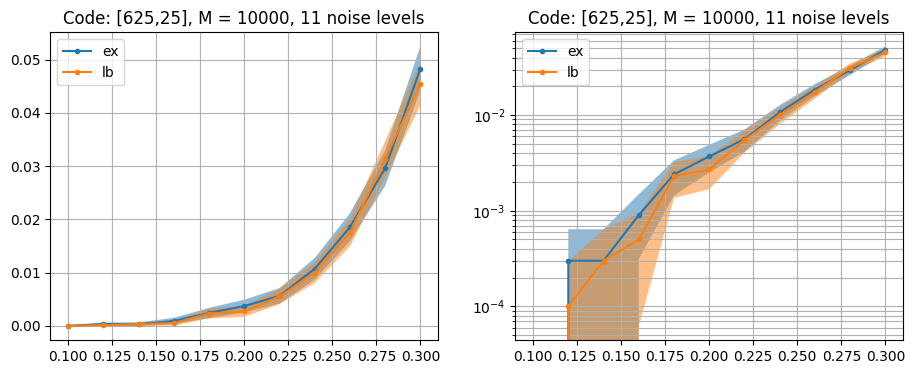

In [21]:
fig, (ax, axlog) = plt.subplots(1, 2, figsize=(11, 4))
ax.set_title(f'Code: {codes[0]}, M = {num_trials}, {len(p_vals)} noise levels')
for d, l in zip([eta_gamma, rank_based], 
                ['ex', 'lb']):
    ax.plot(p_vals, d['mean'], '.-', label=l)
    ax.fill_between(p_vals, 
                     d['mean'] - 1.96*d['std']/np.sqrt(num_trials), 
                     d['mean'] + 1.96*d['std']/np.sqrt(num_trials), 
                     alpha=0.5)
    
ax.legend()
ax.grid(which='both')

axlog.set_title(f'Code: {codes[0]}, M = {num_trials}, {len(p_vals)} noise levels')
for d, l in zip([eta_gamma, rank_based], 
                ['ex', 'lb']):
    axlog.semilogy(p_vals, d['mean'], '.-', label=l)
    axlog.fill_between(p_vals, 
                     d['mean'] - 1.96*d['std']/np.sqrt(num_trials), 
                     d['mean'] + 1.96*d['std']/np.sqrt(num_trials), 
                     alpha=0.5)
    
axlog.legend()
axlog.grid(which='both')

plt.show()

### What have we learned so far?
- The rank-based approach is supposed to be a lower bound to the eta-gamma approach, but so far I haven't found evidence of it being any lower. I.e., it's accurate enough.
- Surprisingly, the rank-based approach is SLOWER than the eta-gamma approach. This should be due to excessive overhead when converting to M4RI. We must refactor the whole Monte Carlo estimation directly in C to avoid this overhead.
- Actually, upon further consideration, it actually makes sense that rank-based is slower because the operations involved in both approaches are basically the same (echelonize some matrices), but in the rank-based approach, we always have to compute the rank of a relatively large matrix, $H_{\bar{\mathcal{E}}}$, whereas in the eta-gamma approach, only the $H_{\mathcal{E}}$ matrix is exploited at each iteration.
- About the C refactoring, did that, and at first, much to my horror, the Python version for the eta-gamma approach was actually faster. I managed to rework the C version to make it faster, but so far it is only slightly faster than the Python version. For the rank-based method, it sped up by a factor of about 5, but it's still slower than eta-gamma. 
- The relation between P(x_logical_error) and P(x_logical_error or z_logical_error) is not as simple as I thought. X and Z logical errors do not seem to be independent nor simultaneous, but correlated with some nontrivial positive correlation. However, for optimization purposes, computing only the x logical error rate should be fine, as the relation between those two quantities is still supposed to be monotonic.
- As expected, the X_only variations are roughly twice as fast as their X|Z counterparts. 
- As logic mandates, the symplectic variant of the rank based approach is indeed slower and the little advantage it had was for very small codes only.
- Takeaway numbers: ~$8$s for $10^4$ MC trials per value of $p$, by using the eta-gamma X|Z approach. (Python implementation).
- Takeaway numbers: ~$6.5$s for $10^4$ MC trials per value of $p$, by using the eta-gamma X|Z approach. (C implementation).
- Note: these numbers depend a lot on the particular noise levels. In general, the time is grows with the noise level, and so does the advantage of the C implementation vs. the Python one. 

## Testing on larger codes

In [8]:
# draw_bpt_graph(new_state)
# draw_hgp_graph(new_state, fontsize=0, nodesize=50)

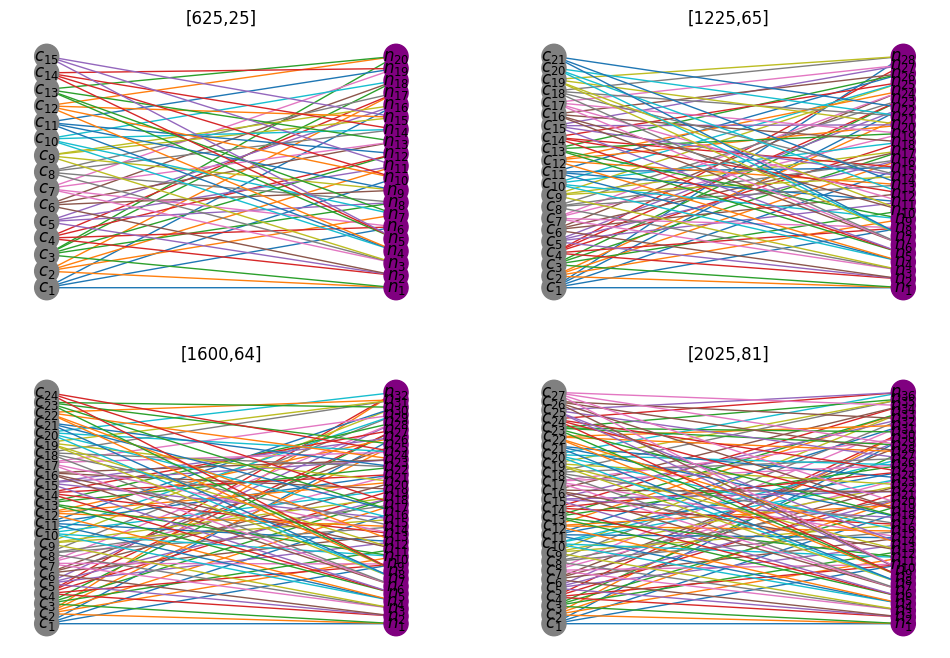

In [5]:
states = {txt: load_tanner_graph(txt) for txt in textfiles}

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for lbl, txt, ax in zip(codes, states, axs.flatten()):
    ax.set_title(lbl)
    draw_bpt_graph(states[txt], ax)

plt.show()


# fig, axs = plt.subplots(2, 2, figsize=(12, 8))
# for lbl, txt, ax in zip(codes, states, axs.flatten()):
#     ax.set_title(lbl)
#     draw_hgp_graph(states[txt], fontsize=0, nodesize=10, ax=ax)

# plt.show()

In [6]:
report, stats = {name: {} for name in codes}, {name: {} for name in codes}

num_trials = int(1e4)
p_vals = np.linspace(1e-1, 5e-1, 17)

report['p_vals'] = p_vals
report['M'] = num_trials

# Run experiments - takes a loooooong time
for name, state in zip(codes, states.values()):
    
    report[name]['ex'] = %timeit -o css.MC_erasure_plog(num_trials, state, p_vals)
    report[name]['lb'] = %timeit -o css.MC_erasure_plog(num_trials, state, p_vals, rank_method=True)
    
    stats[name]['ex'] = css.MC_erasure_plog(num_trials, state, p_vals)
    stats[name]['lb'] = css.MC_erasure_plog(num_trials, state, p_vals, rank_method=True)


2min 20s ± 805 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5min 35s ± 6.02 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
8min 18s ± 2.25 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
23min 56s ± 5.94 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
14min 29s ± 2.13 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
37min 32s ± 35.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
24min 10s ± 4.33 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
1h 47s ± 17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
times = {name: {} for name in codes}
for name in codes:
    for mode in ['ex', 'lb']: #
        t = np.array(report[name][mode].timings)
        times[name][mode] = {'mean': t.mean(), 'std': t.std()}


In [8]:
# Save report, times, stats
import pickle

with open('simulations_C_1e4.pkl', 'wb') as file:
    data = [report, times, stats]
    pickle.dump(data, file)

# with open('simulations.pkl', 'rb') as file:
#     report, times, stats = pickle.load(file)

In [9]:
for name in codes:
    print(f"Code: {name}")
    print(f"M = {report['M']}")
    print(f"p_s = {report['p_vals']}")
    print(f" eta-gamma runtime: {report[name]['ex'].__str__().split('per loop')[0]}")
    print(f"rank based runtime: {report[name]['lb'].__str__().split('per loop')[0]}")
    print()
    

Code: [625,25]
M = 10000
p_s = [0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3   0.325 0.35  0.375
 0.4   0.425 0.45  0.475 0.5  ]
 eta-gamma runtime: 2min 20s ± 805 ms 
rank based runtime: 5min 35s ± 6.02 s 

Code: [1225,65]
M = 10000
p_s = [0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3   0.325 0.35  0.375
 0.4   0.425 0.45  0.475 0.5  ]
 eta-gamma runtime: 8min 18s ± 2.25 s 
rank based runtime: 23min 56s ± 5.94 s 

Code: [1600,64]
M = 10000
p_s = [0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3   0.325 0.35  0.375
 0.4   0.425 0.45  0.475 0.5  ]
 eta-gamma runtime: 14min 29s ± 2.13 s 
rank based runtime: 37min 32s ± 35.1 s 

Code: [2025,81]
M = 10000
p_s = [0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3   0.325 0.35  0.375
 0.4   0.425 0.45  0.475 0.5  ]
 eta-gamma runtime: 24min 10s ± 4.33 s 
rank based runtime: 1h 47s ± 17 s 



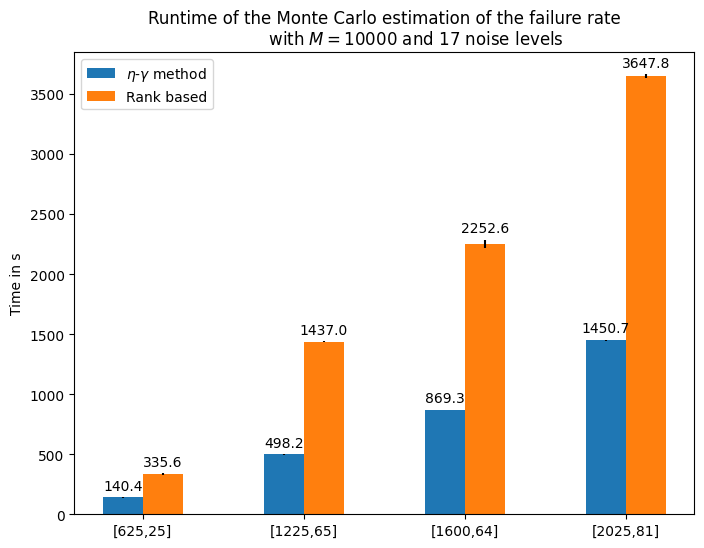

In [12]:
methods = {'ex': r'$\eta$-$\gamma$ method', 'lb': r'Rank based'}

plt.figure(figsize=(8,6))
plt.title(f'''Runtime of the Monte Carlo estimation of the failure rate
            with $M = {num_trials}$ and {p_vals.size} noise levels''')

width = 0.25
for i, mode in enumerate(['ex', 'lb']):
    means = [times[name][mode]['mean'] for name in codes]
    stds = [times[name][mode]['std'] for name in codes]
    
    bars = plt.bar(np.arange(len(codes)) + width*(i-.5), means, width, 
                   yerr=stds, label=methods[mode], align='center')
    plt.bar_label(bars, padding=3, fmt=lambda x: f'{x:.1f}')
    

plt.ylabel('Time in s')
plt.xticks(np.arange(len(codes)), labels=codes)
plt.legend()

plt.show()

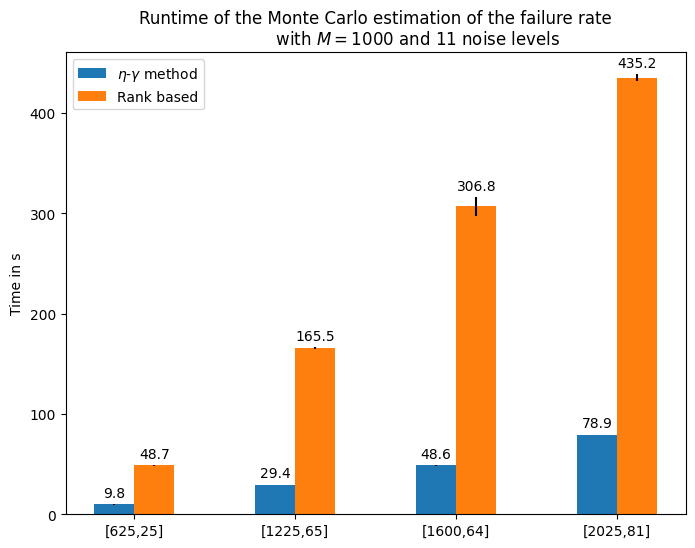

In [24]:
# DON'T TOUCH THIS!!!!!!!!!

# methods = {'ex': r'$\eta$-$\gamma$ method', 'lb': r'Rank based'}

# plt.figure(figsize=(8,6))
# plt.title(f'''Runtime of the Monte Carlo estimation of the failure rate
#                 with $M = {num_trials}$ and {p_vals.size} noise levels''')

# width = 0.25
# for i, mode in enumerate(['ex', 'lb']):
#     means = [times[name][mode]['mean'] for name in codes]
#     stds = [times[name][mode]['std'] for name in codes]
    
#     bars = plt.bar(np.arange(len(codes)) + width*(i-.5), means, width, 
#                    yerr=stds, label=methods[mode], align='center')
#     plt.bar_label(bars, padding=3, fmt=lambda x: f'{x:.1f}')
    

# plt.ylabel('Time in s')
# plt.xticks(np.arange(len(codes)), labels=codes)
# plt.legend()

# plt.show()

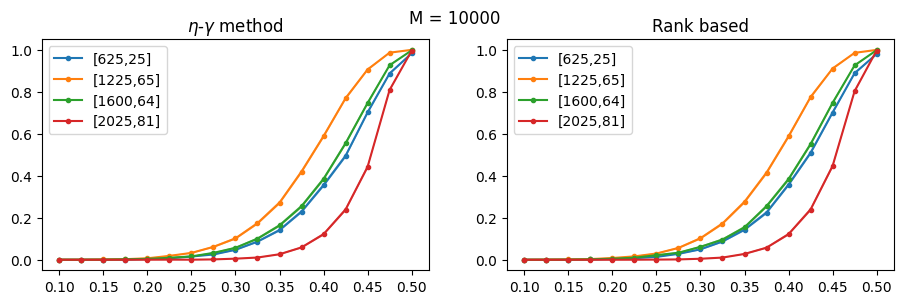

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(11,3))
plt.suptitle(f'M = {num_trials}')

for mode, ax in zip(['ex', 'lb'], axs):
    ax.set_title(methods[mode])
    means = np.vstack([stats[name][mode]['mean'] for name in codes])
    stds = np.vstack([stats[name][mode]['std'] for name in codes])
    
    for m, s, name in zip(means, stds, codes):
        ax.plot(p_vals, m, '.-', label=name)
        ax.fill_between(p_vals, m - 1.96*s/np.sqrt(num_trials), 
                         m + 1.96*s/np.sqrt(num_trials), alpha=0.5)
    
    ax.legend()

plt.show()

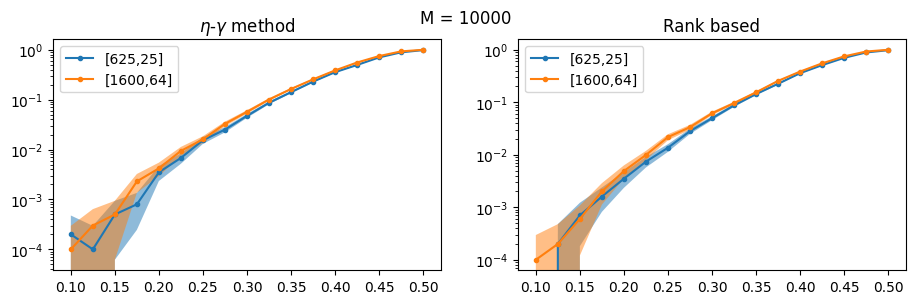

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(11,3))
plt.suptitle(f'M = {num_trials}')

for mode, ax in zip(['ex', 'lb'], axs):
    ax.set_title(methods[mode])
    means = np.vstack([stats[name][mode]['mean'] for name in codes[::2]])
    stds = np.vstack([stats[name][mode]['std'] for name in codes[::2]])
    
    for m, s, name in zip(means, stds, codes[::2]):
        ax.semilogy(p_vals, m, '.-', label=name)
        ax.fill_between(p_vals, m - 1.96*s/np.sqrt(num_trials), 
                         m + 1.96*s/np.sqrt(num_trials), alpha=0.5)
    
    ax.legend()

plt.show()

In [52]:
res_0 = css.MC_erasure_plog(num_trials=int(1e4), state=states[textfiles[0]], p_vals=[9/32])
res_1 = css.MC_erasure_plog(num_trials=int(1e4), state=states[textfiles[1]], p_vals=[8/32])
res_2 = css.MC_erasure_plog(num_trials=int(1e4), state=states[textfiles[2]], p_vals=[9/32])
res_3 = css.MC_erasure_plog(num_trials=int(1e4), state=states[textfiles[3]], p_vals=[12/32])

In [54]:
%timeit res_0 = css.MC_erasure_plog(num_trials=int(1e4), state=states[textfiles[0]], p_vals=[9/32])
%timeit res_1 = css.MC_erasure_plog(num_trials=int(1e4), state=states[textfiles[1]], p_vals=[8/32])
%timeit res_2 = css.MC_erasure_plog(num_trials=int(1e4), state=states[textfiles[2]], p_vals=[9/32])
%timeit res_3 = css.MC_erasure_plog(num_trials=int(1e4), state=states[textfiles[3]], p_vals=[12/32])

8.51 s ± 58.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
27 s ± 633 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
49.3 s ± 354 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 53s ± 1.02 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
for res in [res_0, res_1, res_2, res_3]:
    m, s = res['mean'][0], res['std'][0]/np.sqrt(num_trials)
    print(f"{m:.3g} +- {s:.3g} | {s/m:.3g}")

0.0308 +- 0.00173 | 0.0561
0.0329 +- 0.00178 | 0.0542
0.0413 +- 0.00199 | 0.0482
0.0576 +- 0.00233 | 0.0405


# Simulated Annealing

In [20]:
from css_code_eval import *
from simulated_annealing import *
import h5py

codes = ['[625,25]', '[1225,65]', '[1600,64]', '[2025,81]']
textfiles = [f"HGP_(3,4)_{code}.txt" for code in codes]

cost_function = lambda state: MC_erasure_plog_fixed_p(10000, state, 0.3)
history, cost_history = simulated_annealing(cost_function=cost_function, 
                                            random_neighbor=generate_neighbor, 
                                            schedule=arctan_diff_schedule, 
                                            theta0=load_tanner_graph(textfiles[0]), 
                                            epsilon=0., max_iterations=100)
# x = np.array(list(env.state.edges(data=False))).flatten()

# B = nx.MultiGraph()
# B.add_nodes_from(np.arange(m), bipartite=0)
# B.add_nodes_from(np.arange(m+1, m+n), bipartite=1)
# B.add_edges_from([tuple(r) for r in x.reshape(-1, 2)])

# B.edges(data=False)


# with h5py.File("sim_ann.hdf5", "w") as f:    
#     for code in codes:
#         grp = f.create_dataset(f"sim_ann/{code}", (100,), dtype=np.uint8)
#         grp.attrs['cost'] = 0.0
#     print(f['sim_ann/[625,25]'])
#     print(grp.attrs['cost'])




100%|█████████████████████████████████████████| 100/100 [20:11<00:00, 12.12s/it]


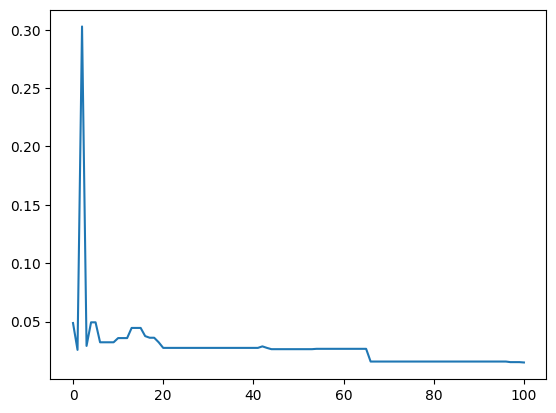

In [21]:
plt.plot(cost_history)

In [23]:
cost_history[0], cost_history[-1]

(0.0487, 0.0149)

## Exploring the cost function across the state space

In order to understand how to choose the Monte Carlo budget, the physical noise level, and, in a second moment, how to properly tune the Simulated Annealing algorithm as well as the several parameters in the Projective Simulation framework, we need to understand how the cost function (i.e., the estimated logical error rate for the erasure channel) varies across a sample of the state space. 

We'll do so by exploring the space at random, i.e., doing a random walk along the states, and evaluating the states along the path, as well as a small part of its neighborhood, to understand how the function varies between neighboring states. 

This is important to give us a hint on whether the pre-defined Monte Carlo budget is enough to correctly compare the quality of two distinct (especially neighboring) states. In other words, we need to check that the variation of the function across different states is of a higher order of magnitude than the stochastic fluctuations arising from the Monte Carlo estimation of such quality. 

If the variation of the function across different states is smaller than or of the same order as the standard deviation of the MC estimator, we are doomed, i.e., the proposed MC budget is insufficient for the optimization endeavor. We would either need to increase it to the point that its variance is considerably smaller than the usual variability of the function (which is a disadvantageous tradeoff), or think of another way to make the cost function vary more (e.g., take multiple wire-crossing steps at a time, thus leading to farther states, whose quality may differ more significantly from that of the previous state). 

In [26]:
import h5py

In [39]:
fn_data = {}

with h5py.File('exploration.hdf5', 'r') as f:
    for code, grp in f.items():
        fn_data[code] = grp['values'][()].copy()
    

In [40]:
exploration_params = {code: par for code, par in zip(codes, [(24, 120), (15, 70), (12, 40), (8, 30)])}

In [43]:
for code in fn_data:
    fn_data[code] = fn_data[code].reshape(exploration_params[code])

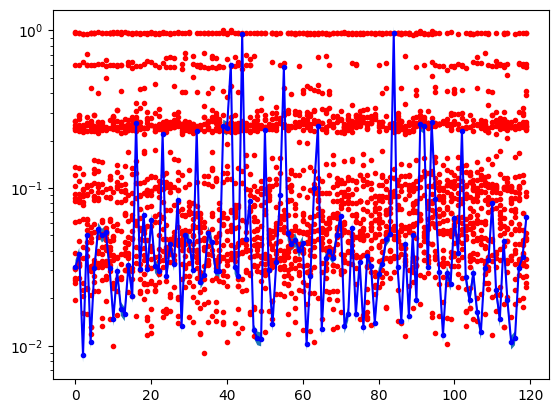

In [115]:
data_0 = fn_data[codes[0]]
plt.figure()

x = np.arange(len(data_0.T))
plt.semilogy(x, data_0[1:].T, 'r.')
plt.semilogy(x, data_0[0].T, 'b.-')
plt.fill_between(x, 0.9*data_0[0].T, 1.1*data_0[0].T, alpha=1)
# plt.xlim([0, 19])
# plt.ylim([8e-3, 7e-2])
plt.show()

In [125]:
fn_data[codes[2]].min()

0.002

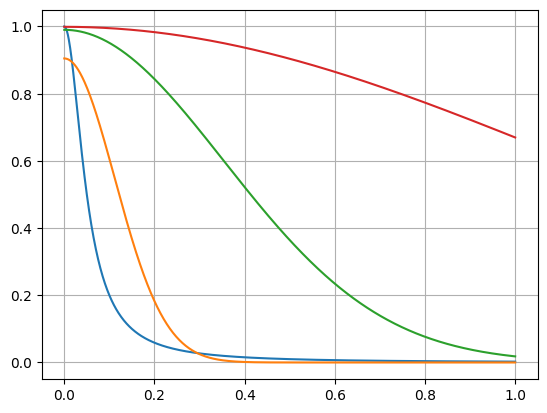

In [109]:
a = 400.
t = np.linspace(0., 1., 1000)
plt.plot(t, 1/(1 + a*t**2))
plt.plot(t, np.exp(-(1e-1)*(1+a*t**2)))
plt.plot(t, np.exp(-(1e-2)*(1+a*t**2)))
plt.plot(t, np.exp(-(1e-3)*(1+a*t**2)))
plt.grid('minor')

In [25]:
# x = np.array(list(env.state.edges(data=False))).flatten()

# B = nx.MultiGraph()
# B.add_nodes_from(np.arange(m), bipartite=0)
# B.add_nodes_from(np.arange(m+1, m+n), bipartite=1)
# B.add_edges_from([tuple(r) for r in x.reshape(-1, 2)])

# B.edges(data=False)


# with h5py.File("sim_ann.hdf5", "w") as f:    
#     for code in codes:
#         grp = f.create_dataset(f"sim_ann/{code}", (100,), dtype=np.uint8)
#         grp.attrs['cost'] = 0.0
#     print(f['sim_ann/[625,25]'])
#     print(grp.attrs['cost'])

# np.array(sorted(new_state.edges(data=False))).shape

# np.array(sorted(new_state.edges(data=False)))
diam = lambda arr: np.max(arr) - np.min(arr) + 1
for i in range(4):
    new_state = load_tanner_graph(textfiles[i])
    m, n = np.apply_along_axis(diam, 0, np.array(sorted(new_state.edges(data=False))))
    E = len(np.array(sorted(new_state.edges(data=False))))
    print((m, n, E))

(15, 20, 60)
(21, 28, 84)
(24, 32, 96)
(27, 36, 108)
